In [1]:
import torch
from torch import autograd
from torch import nn
import torchvision
from torch import optim
import torchvision.transforms as transforms
from tqdm.notebook import tqdm
import numpy as np
from models import SCrossEntropyLoss, SMLP3, SMLP4
from Functions import SCrossEntropyLossFunction
from tqdm.notebook import tqdm

In [2]:
def eval():
    total = 0
    correct = 0
    model.clear_noise()
    model.clear_mask()
    with torch.no_grad():
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            images = images.view(-1, 784)
            outputs = model(images)
            predictions = outputs.argmax(dim=1)
            correction = predictions == labels
            correct += correction.sum()
            total += len(correction)
    return correct/total

def Seval(is_clear_mask=True):
    total = 0
    correct = 0
    with torch.no_grad():
        model.clear_noise()
        if is_clear_mask:
            model.clear_mask()
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            images = images.view(-1, 784)
            outputs = model(images)
            predictions = outputs[0].argmax(dim=1)
            correction = predictions == labels
            correct += correction.sum()
            total += len(correction)
    return (correct/total).cpu().numpy()

def Seval_noise(var, is_clear_mask=True):
    total = 0
    correct = 0
    model.clear_noise()
    if is_clear_mask:
        model.clear_mask()
    with torch.no_grad():
        model.set_noise(var)
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            images = images.view(-1, 784)
            outputs = model(images)
            predictions = outputs[0].argmax(dim=1)
            correction = predictions == labels
            correct += correction.sum()
            total += len(correction)
    return (correct/total).cpu().numpy()

def STrain(epochs):
    best_acc = 0.0
    for i in range(epochs):
        running_loss = 0.
        running_l = 0.
        for images, labels in trainloader:
            optimizer.zero_grad()
            images, labels = images.to(device), labels.to(device)
            images = images.view(-1, 784)
            outputs, outputsS = model(images)
            loss = criteria(outputs, outputsS,labels)
            loss.backward()
            l = loss + model.fetch_S_grad()
            optimizer.step()
            running_loss += loss.item()
            running_l += l.item()
        test_acc = Seval()
        if test_acc > best_acc:
            best_acc = test_acc
            torch.save(model.state_dict(), "tmp_best.pt")
        print(f"epoch: {i:-3d}, test acc: {test_acc:.4f}, loss: {running_loss / len(trainloader):.4f}, s: {(running_l - running_loss) / len(trainloader):-5.4f}")

def GetSecond():
    running_loss = 0.
    running_l = 0.
    optimizer.zero_grad()
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        images = images.view(-1, 784)
        outputs, outputsS = model(images)
        loss = criteria(outputs, outputsS,labels)
        loss.backward()

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

BS = 128

trainset = torchvision.datasets.MNIST(root='~/testCode/data', train=True,
                                        download=False, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BS,
                                        shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='~/testCode/data', train=False,
                                    download=False, transform=transforms.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=BS,
                                            shuffle=False, num_workers=2)

In [57]:
device = torch.device("cuda:0")
model = SMLP4()
model.to(device)
model.push_S_device()
model.clear_noise()
model.clear_mask()
criteria = SCrossEntropyLossFunction.apply
optimizer = optim.Adam(model.parameters(), lr=0.01)

STrain(20)

epoch:   0, test acc: 0.9400, loss: 0.3459, s: 11018.7564
epoch:   1, test acc: 0.9528, loss: 0.1771, s: 11523.3947
epoch:   2, test acc: 0.9393, loss: 0.1479, s: 14943.5469
epoch:   3, test acc: 0.9534, loss: 0.1349, s: 19002.9325
epoch:   4, test acc: 0.9623, loss: 0.1199, s: 22760.3568
epoch:   5, test acc: 0.9624, loss: 0.1128, s: 27362.5771
epoch:   6, test acc: 0.9563, loss: 0.1073, s: 31667.9483
epoch:   7, test acc: 0.9602, loss: 0.1045, s: 35821.4841
epoch:   8, test acc: 0.9605, loss: 0.1022, s: 40596.5504
epoch:   9, test acc: 0.9609, loss: 0.0944, s: 44960.3244
epoch:  10, test acc: 0.9638, loss: 0.0986, s: 52877.6223
epoch:  11, test acc: 0.9639, loss: 0.0890, s: 58248.1687
epoch:  12, test acc: 0.9649, loss: 0.0895, s: 66769.9517
epoch:  13, test acc: 0.9632, loss: 0.0858, s: 74833.6446
epoch:  14, test acc: 0.9615, loss: 0.0867, s: 85070.7623
epoch:  15, test acc: 0.9640, loss: 0.0835, s: 103415.3159
epoch:  16, test acc: 0.9643, loss: 0.0804, s: 104047.7664
epoch:  17, 

In [58]:
state_dict = torch.load("tmp_best.pt")
model.load_state_dict(state_dict)
model.clear_mask()
model.set_mask(0)
print(model.fc1.mask)
print(Seval(False))
torch.save(model.state_dict(), "saved.pt")

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]], device='cuda:0')
0.96489996


In [5]:
no_mask_acc_list = []
state_dict = torch.load("saved.pt")
model.load_state_dict(state_dict)
model.clear_mask()
loader = tqdm(range(100))
for _ in loader:
    acc = Seval_noise(0.1,False)
    no_mask_acc_list.append(acc)
    loader.set_description(f"{np.mean(no_mask_acc_list):.4f}")
print(f"average: {np.mean(no_mask_acc_list)}, std: {np.std(no_mask_acc_list)}")


average: 0.932811975479126, std: 0.014683802612125874


In [6]:
state_dict = torch.load("saved.pt")
model.load_state_dict(state_dict)
GetSecond()
mask_acc_list = []
model.clear_mask()
print(f"without mask: {Seval(False):.4f}")
model.set_mask(0.01)
optimizer = optim.SGD(model.parameters(), lr=1e-3)
print(f"with mask: {Seval(False)}")
STrain(1)
loader = tqdm(range(100))
for _ in loader:
    acc = Seval_noise(0.1,False)
    mask_acc_list.append(acc)
    loader.set_description(f"{np.mean(mask_acc_list):.4f}")
print(f"average: {np.mean(mask_acc_list)}, std: {np.std(mask_acc_list)}")

without mask: 0.9654
with mask: 0.9631999731063843
epoch:   0, test acc: 0.9657, loss: 0.0650, s: 14644.9166



average: 0.9371699690818787, std: 0.01206662692129612


In [68]:
device = torch.device("cuda:0")
state_dict = torch.load("saved.pt")
model.load_state_dict(state_dict)
model.to(device)
model.clear_noise()
model.clear_S_grad()
model.clear_mask()
GetSecond()

In [69]:
from matplotlib import pyplot as plt

In [70]:
fc1_gradS_B = model.fc1.weightS.grad.data.cpu().view(-1).numpy()
fc2_gradS_B = model.fc2.weightS.grad.data.cpu().view(-1).numpy()
fc3_gradS_B = model.fc3.weightS.grad.data.cpu().view(-1).numpy()
fc4_gradS_B = model.fc4.weightS.grad.data.cpu().view(-1).numpy()

In [76]:
w = model.fc3.op.weight.data.cpu().view(-1).numpy()

Text(0, 0.5, 'weight')

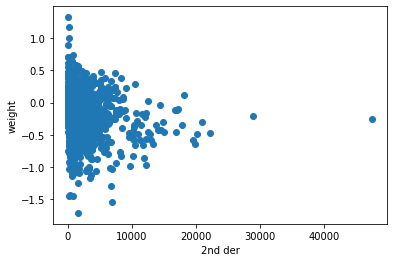

In [77]:
plt.scatter(fc3_gradS_B,w)
plt.xlabel("2nd der")
plt.ylabel("weight")

In [62]:
model.clear_noise()
model.clear_S_grad()
model.set_mask(0.05)
STrain(1)
GetSecond()

epoch:   0, test acc: 0.9602, loss: 0.1005, s: 79789.4157


In [63]:
fc1_gradS_A = (model.fc1.weightS.grad.data * model.fc1.mask).cpu().view(-1).numpy()
# fc1_gradS_A = (model.fc1.weightS.grad.data).cpu().view(-1).numpy()
fc2_gradS_A = (model.fc2.weightS.grad.data * model.fc2.mask).cpu().view(-1).numpy()
fc3_gradS_A = (model.fc3.weightS.grad.data * model.fc3.mask).cpu().view(-1).numpy()
fc4_gradS_A = (model.fc4.weightS.grad.data * model.fc4.mask).cpu().view(-1).numpy()

661.292
744.72
25088
25088


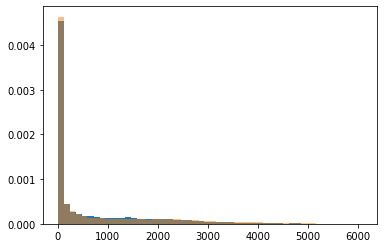

In [78]:
_ = plt.hist(fc1_gradS_B, bins=50, alpha=1, density=True)
_ = plt.hist(fc1_gradS_A, bins=50, alpha=0.5, density=True)
print(fc1_gradS_B.mean())
print(fc1_gradS_A.mean())
print(len(fc1_gradS_B))
print(len(fc1_gradS_A))

15523.158
18553.3
1024
1024


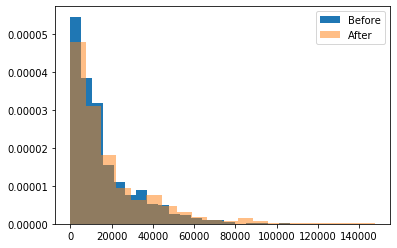

In [82]:
_ = plt.hist(fc2_gradS_B, bins=20, alpha=1, density=True)
_ = plt.hist(fc2_gradS_A, bins=20, alpha=0.5, density=True)
print(fc2_gradS_B.mean())
print(fc2_gradS_A.mean())
print(len(fc2_gradS_B))
print(len(fc2_gradS_A))
plt.legend(["Before", "After"])

2465.1816
2536.954
1024
1024


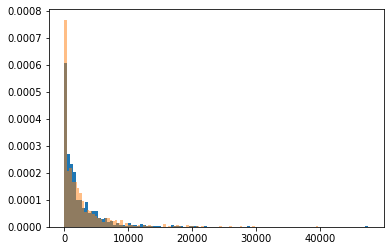

In [66]:
_ = plt.hist(fc3_gradS_B, bins=100, alpha=1, density=True)
_ = plt.hist(fc3_gradS_A, bins=100, alpha=0.5, density=True)
print(fc3_gradS_B.mean())
print(fc3_gradS_A.mean())
print(len(fc3_gradS_B))
print(len(fc3_gradS_A))

1462.9585
1258.7201
320
320


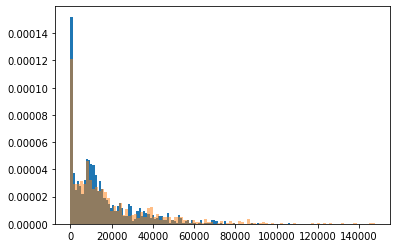

In [67]:
_ = plt.hist(fc2_gradS_B, bins=100, alpha=1, density=True)
_ = plt.hist(fc2_gradS_A, bins=100, alpha=0.5, density=True)
print(fc4_gradS_B.mean())
print(fc4_gradS_A.mean())
print(len(fc4_gradS_B))
print(len(fc4_gradS_A))

In [49]:
((fc4_gradS_A == 0).sum()/len(fc4_gradS_A))

0.09375